In [133]:
import networkx as nx
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import pandas as pd
import numpy as np

Reference: Xuezhi Liu Phd 2014 https://orca.cf.ac.uk/57830/1/2014LiuXPhD.pdf

## Input: Network graph topology and geographical coordinates

Load from file: 
* Edgelist
* Node attributes
    * Location
    * Node type

In [268]:
# load incidence matrix
edge_list = pd.read_csv('edge_list.csv', header=0, index_col='pipe_no')
edge_list['from_node']

pipe_no
0      0
1      1
2      1
3      1
4      4
5      4
6      6
7      6
8      6
9      4
10    10
11    10
12    12
13    13
14    14
15    14
16    13
17    13
18    18
19    18
20    18
21    21
22    21
23    21
24    24
25    24
26    24
27    27
28    27
29    30
30    30
31    31
Name: from_node, dtype: int64

In [310]:
G = nx.DiGraph()

edge_attr = ['lenght_m', 'diameter_mm', 'heat_transfer_coefficient_W/mK', 'roughness_mm']
G = nx.from_pandas_edgelist(edge_list, 'from_node', 'to_node', edge_attr=edge_attr, create_using=G)

node_list = pd.read_csv('node_list.csv')
for node in G.nodes:
    G.add_node(node, lon=node_list.loc[int(node)]['lon'],
                      lat=node_list.loc[int(node)]['lat'])

## Plotting

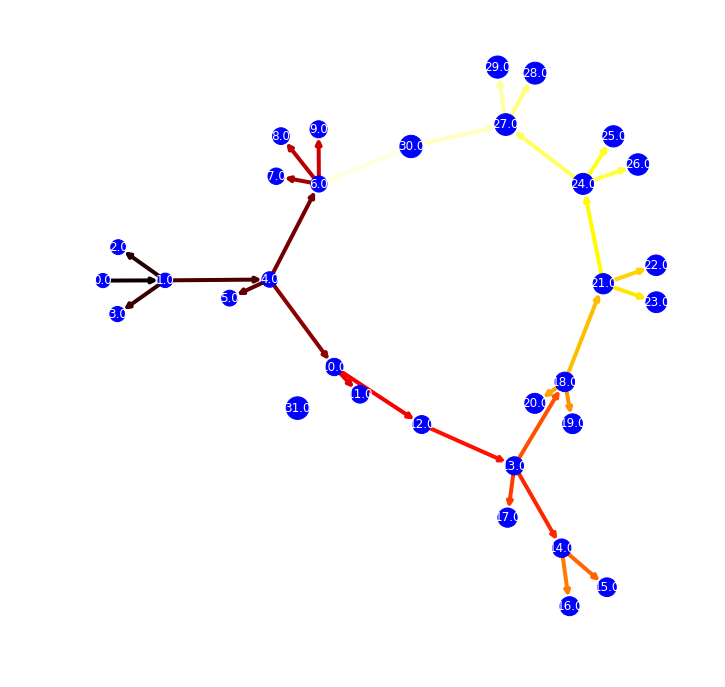

In [311]:
# https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_directed.html

def draw_network(G, node_sizes, edge_colors, edge_width):
    pos = nx.circular_layout(G)
    pos = nx.spring_layout(G)
    pos = nx.fruchterman_reingold_layout(G.to_undirected())
    fig = plt.figure(figsize=(12,12))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
    labels = nx.draw_networkx_labels(G, pos, font_color='w')
    edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=10, edge_color=edge_colors,
                                   edge_cmap=plt.cm.hot, width=edge_width)


    ax = plt.gca()
    ax.set_axis_off()
    plt.show()


node_sizes = [200 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

draw_network(G, node_sizes=node_sizes, edge_colors=edge_colors, edge_width=4)


In [312]:
print(nx.incidence_matrix(G, oriented=True).todense())

[[-1.  0.  0. ...  0.  0.  0.]
 [ 1. -1. -1. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]


## Known consumer flows without loops

In [313]:
def hydraulics_wo_loops(G, m):
    A = nx.incidence_matrix(G, oriented=True).todense()
    m[0] = - 2*np.sum(m[1:])
    print(A.shape)
    print(m.shape)
    print(A)
    print(m)
    flows = np.linalg.lstsq(A,m)[0]
    print('x', flows)
    return flows
    
m = np.random.rand(A.shape[0])
flows = hydraulics_wo_loops(G, m)    

(32, 32)
(32,)
[[-1.  0.  0. ...  0.  0.  0.]
 [ 1. -1. -1. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
[-32.84820599   0.80771127   0.94931935   0.45423305   0.58804395
   0.46278085   0.51123451   0.72394162   0.66486607   0.48264963
   0.91884086   0.90203712   0.21370726   0.23826754   0.50732224
   0.21635924   0.74121938   0.27452989   0.51335824   0.34229338
   0.10738571   0.47906055   0.66286124   0.20109551   0.08242834
   0.99483626   0.94231898   0.82229737   0.47478854   0.11012152
   0.32995713   0.70423639]
x [32.33495277  1.46257256  0.96748627 28.58392945  0.97603407 13.22276151
 13.28383671  1.23719484  1.17811929  0.99590285  1.41529034  9.21896268
  8.49200221  3.00466051  0.78778311  3.94803783  0.72961245  1.2544726
  0.8555466   0.62063893  1.44524083  1.17611446  0.71434873 -1.43753613
  1.50808948  1.4555722  -4.99687937  0.98804175  0.62337474  7.94384645
 -8

/home/local/RL-INSTITUT/jann.launer/Desktop/oemof_repos/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


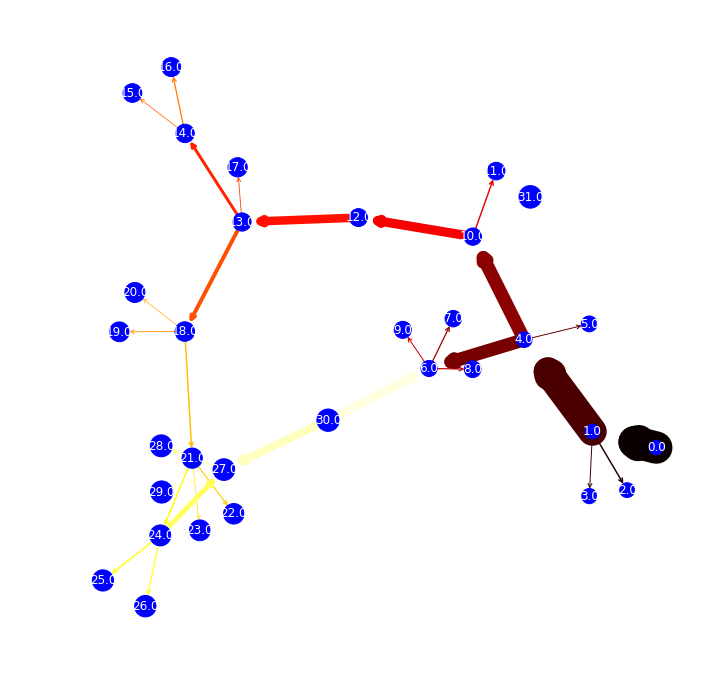

In [314]:
# Need to create a layout when doing
# separate calls to draw nodes and edges
M = G.number_of_edges()
edge_colors = range(2, M + 2)
draw_network(G, node_sizes=node_sizes, edge_colors=edge_colors, edge_width=abs(flows))

## Known consumer flows with loops

## Unknown consumer flows

## Excursion to street networks

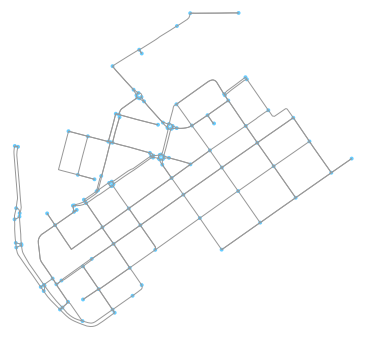

In [315]:
import osmnx as ox
import geopandas as gpd

place_name = "Kamppi, Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')
fig, ax = ox.plot_graph(graph)


In [316]:
for u, v, data in graph.edges(keys=False, data=True):
    print(u)
    print(v)

25216594
1372425714
25238874
1372425713
25238944
25216594
25238944
319896278
25291537
25291591
25291537
25291565
25291537
25292473
25291564
317703609
25291564
25291565
25291564
1377211669
25291565
1377211666
25291565
25291564
25291565
25291537
25291591
60170471
25291591
1377610493
25292473
25291537
25416262
60069401
25416263
1371748760
25416263
282731082
25416267
25416262
56113314
979855850
56113314
846597954
56115897
60278325
56115897
60072524
56115897
295322365
56116937
1372376956
56116937
1372376935
56116937
60004721
56116937
1372425724
57743854
60070287
60004721
1372376937
60004721
1372318837
60004721
268177652
60004721
56116937
60069401
25416262
60070287
1372441203
60070287
57743854
60072524
56115897
60072524
267117319
60072524
3177642345
60170470
1377211668
60170470
1377211669
60170471
1377211668
60170471
1372441170
60170471
1377211667
60278325
56115897
60278325
1372441203
60278325
1378064355
103062861
529507770
103062861
1372425705
103062861
1372376935
148875335
1371748760
14903

In [317]:
# https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.MultiDiGraph.edges.html
graph.edges(data=True, keys=True)


OutMultiEdgeDataView([(25216594, 1372425714, 0, {'osmid': 23856784, 'oneway': True, 'lanes': '2', 'name': 'Mechelininkatu', 'highway': 'primary', 'maxspeed': '40', 'length': 40.885, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f120a48d898>}), (25238874, 1372425713, 0, {'osmid': [29977177, 30470347], 'oneway': True, 'lanes': '3', 'name': 'Mechelininkatu', 'highway': 'primary', 'maxspeed': '40', 'length': 16.601, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f12020a8ef0>}), (25238944, 25216594, 0, {'osmid': [372440330, 8135861], 'oneway': True, 'lanes': '2', 'highway': 'primary', 'maxspeed': '40', 'length': 25.167000000000005, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f12020a8b38>}), (25238944, 319896278, 0, {'osmid': [25514547, 30288797, 30288799], 'oneway': True, 'lanes': '2', 'name': 'Mechelininkatu', 'highway': 'primary', 'maxspeed': '40', 'length': 242.477, 'geometry': <shapely.geometry.linestring.LineString object at 0x7

In [318]:
graph_proj = ox.project_graph(graph)
graph_proj

In [319]:
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)
nodes_proj['x'] = nodes_proj.x.astype(float)
edges_proj

,access,bridge,geometry,highway,junction,key,lanes,length,maxspeed,name,oneway,osmid,u,v
0,NaN,NaN,LINESTRING (384631.3223718022 6671580.07062419...,primary,NaN,0,2,40.885,40,Mechelininkatu,True,23856784,25216594,1372425714
1,NaN,NaN,LINESTRING (384625.7872206579 6671454.38018930...,primary,NaN,0,3,16.601,40,Mechelininkatu,True,"[29977177, 30470347]",25238874,1372425713
2,NaN,NaN,LINESTRING (384643.4732736854 6671561.53381466...,primary,NaN,0,2,25.167,40,NaN,True,"[372440330, 8135861]",25238944,25216594
3,NaN,NaN,LINESTRING (384643.4732736854 6671561.53381466...,primary,NaN,0,2,242.477,40,Mechelininkatu,True,"[25514547, 30288797, 30288799]",25238944,319896278
4,NaN,NaN,LINESTRING (385515.6177361084 6671500.06512665...,tertiary,NaN,0,NaN,139.183,"[30, 40]",Fredrikinkatu,True,"[30568275, 36729015, 316590744, 316590745, 316...",25291537,25291591
5,NaN,NaN,LINESTRING (385515.6177361084 6671500.06512665...,tertiary,NaN,0,NaN,156.783,30,Bulevardi,False,"[42919371, 42919372, 42919373, 42919374, 42919...",25291537,25291565
6,NaN,NaN,LINESTRING (385515.6177361084 6671500.06512665...,tertiary,NaN,0,2,170.506,30,Bulevardi,False,"[333061568, 333061571, 333061573, 572656872, 8...",25291537,25292473
7,NaN,NaN,LINESTRING (385779.465694473 6671672.812754457...,tertiary,NaN,0,2,89.803,30,Bulevardi,False,"[42919365, 42919366, 30955822, 42919367]",25291564,317703609
8,NaN,NaN,LINESTRING (385779.465694473 6671672.812754457...,tertiary,NaN,0,"[3, 2]",157.690,30,Bulevardi,False,"[76334538, 217644146, 76334539, 42919373]",25291564,25291565
9,NaN,NaN,LINESTRING (385779.465694473 6671672.812754457...,residential,NaN,0,2,138.186,30,Yrjönkatu,False,"[62212960, 76333545, 76333547, 36726223, 36726...",25291564,1377211669


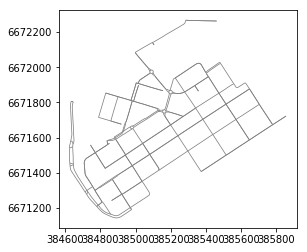

In [320]:
fig, ax = plt.subplots()
edges_proj.plot(ax=ax, linewidth=0.75, color='gray')
plt.show()

In [321]:
place_name_out = place_name.replace(' ', '_').replace(',','')
nodes_out = r"shapefiles/%s_nodes.shp" % place_name_out
streets_out = r"shapefiles/%s_streets.shp" % place_name_out

invalid_cols = ['lanes', 'maxspeed', 'name', 'oneway', 'osmid']
for col in invalid_cols:
    edges_proj[col] = edges_proj[col].astype(str)
edges_proj.to_file(streets_out)
nodes_proj.to_file(nodes_out)

In [322]:
nodes_proj.loc[1372425714]

highway                                             NaN
lat                                             60.1644
lon                                              24.921
osmid                                        1372425714
x                                                384624
y                                           6.67154e+06
geometry    POINT (384624.1787626689 6671539.986316172)
Name: 1372425714, dtype: object

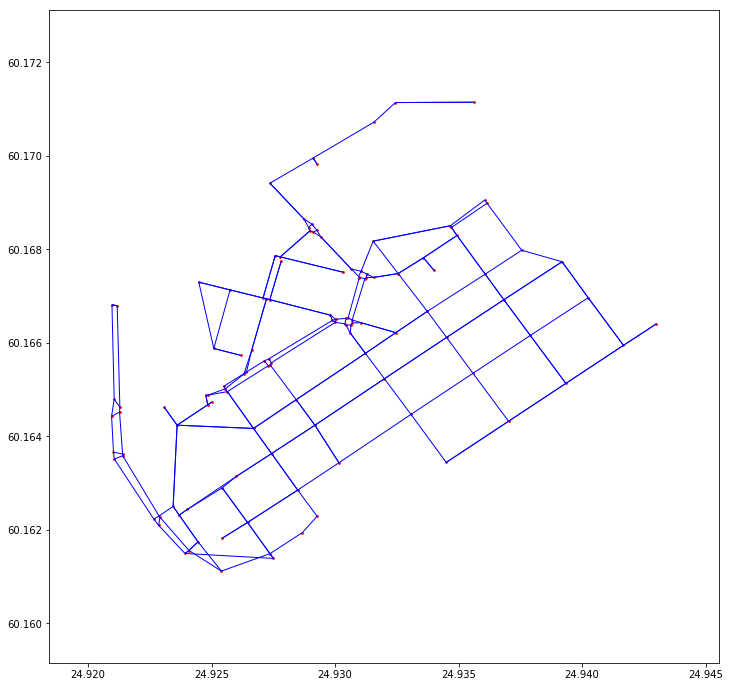

In [323]:
from matplotlib.collections import LineCollection


def draw_graph(G, fig_width, fig_height, bgcolor='w',
               use_geom=False, edge_color='b', edge_linewidth=1,
               edge_alpha=1, node_size=3, node_color='r', node_alpha=1,
               node_edgecolor='r', node_zorder=1):

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    lines = []
    for u, v, data in G.edges(data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=edge_color, linewidths=edge_linewidth, alpha=edge_alpha, zorder=2)
    ax.add_collection(lc)

    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    plt.show()
    

bgcolor = 'w'
use_geom = False
edge_color = 'b'
edge_linewidth = 1
edge_alpha = 1

node_size = 3
node_color = 'r'
node_alpha = 1
node_edgecolor = 'r'
node_zorder = 1
draw_graph(graph, 12, 12)

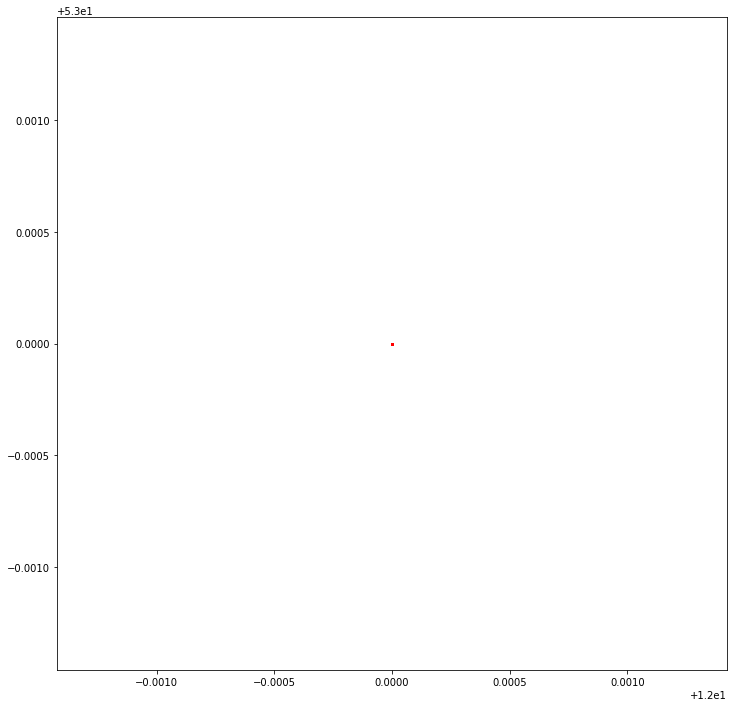

In [328]:
def draw_G(G, fig_width, fig_height, bgcolor='w',
               use_geom=False, edge_color='b', edge_linewidth=1,
               edge_alpha=1, node_size=3, node_color='r', node_alpha=1,
               node_edgecolor='r', node_zorder=1):

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    lines = []
    for u, v, data in G.edges(data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['lon']
            y1 = G.nodes[u]['lat']
            x2 = G.nodes[v]['lon']
            y2 = G.nodes[v]['lat']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=edge_color, linewidths=edge_linewidth, alpha=edge_alpha, zorder=2)
    ax.add_collection(lc)

    node_Xs = [float(x) for _, x in G.nodes(data='lon')]
    node_Ys = [float(y) for _, y in G.nodes(data='lat')]
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    plt.show()

draw_G(G, 12, 12)